In [26]:
import torch
import matplotlib.pyplot as plt

###### Noise Scheduler

In [22]:
class LinearNoiseScheduler():
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise
    
    def sample_prev_timestep(self, xt, t, noise_pred):
        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)/(self.sqrt_alphas_cum_prod[t])
        x0 = torch.clamp(x0, -1, 1)

        mean = xt - ((1 - self.alphas[t])/self.sqrt_one_minus_alpha_cum_prod[t]) * noise_pred
        mean = mean/torch.sqrt(self.alphas[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alphas_cum_prod[t-1])/(1 - self.alphas_cum_prod[t])
            variance = variance*self.betas[t]
            sigma = torch.sqrt(variance)

            z = torch.randn_like(xt).to(xt.device)

            return mean + sigma*z, x0

In [23]:
linear_scheduler = LinearNoiseScheduler(1000, 0.1, 1.0)

Text(0.5, 1.0, 'Sqrt One Minus Alpha Cum Prod')

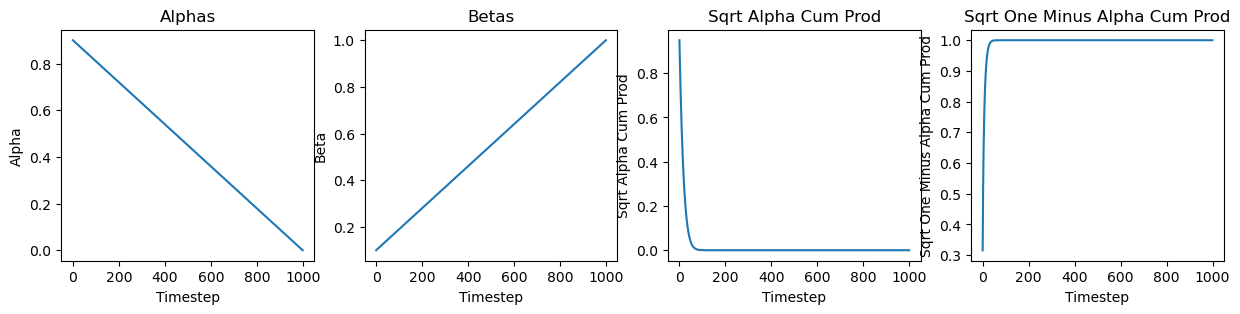

In [37]:
plt.figure(figsize=(15,3))
plt.subplot(1,4,1)
plt.plot(linear_scheduler.alphas)
plt.xlabel('Timestep')
plt.ylabel('Alpha')
plt.title('Alphas')

plt.subplot(1,4,2)
plt.plot(linear_scheduler.betas)
plt.xlabel('Timestep')
plt.ylabel('Beta')
plt.title('Betas')

plt.subplot(1,4,3)
plt.plot(linear_scheduler.sqrt_alphas_cum_prod)
plt.xlabel('Timestep')
plt.ylabel('Sqrt Alpha Cum Prod')
plt.title('Sqrt Alpha Cum Prod')

plt.subplot(1,4,4)
plt.plot(linear_scheduler.sqrt_one_minus_alpha_cum_prod)
plt.xlabel('Timestep')
plt.ylabel('Sqrt One Minus Alpha Cum Prod')
plt.title('Sqrt One Minus Alpha Cum Prod')


TODO: 
- Result of this scheduler on an Image represneting the forward process. 